In [56]:
import pandas as pd
import numpy as np
import datetime
import os
import json
import glob
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
%matplotlib inline


In [2]:
with open('../parameters.json') as json_data :
    params = json.load(json_data)
#Constante souvent mise en majuscule=> nom de dossier, etc.
#on assigne les directory aux dossiers qu'on a créé

DATA_DIR = params['DIRECTORIES']['DATA_DIR']
TMP_DIR = params['DIRECTORIES']['TMP_DIR']    
PRICE_FILE = params['FILES']['PRICE_FILE']
STATION_FILE = params['FILES']['STATION_FILE']
SERVICE_FILE = params['FILES']['SERVICE_FILE']
#Autre méthode de lecture, pour éviter d'avoir à remettre os.path.join à chaque fois
GAS_DB = os.path.join(DATA_DIR,params['DATABASE']['GAS_DB']) 

In [3]:
dfall = pd.read_pickle(os.path.join(DATA_DIR,PRICE_FILE))
df_services = pd.read_pickle(os.path.join(DATA_DIR,SERVICE_FILE))
df_stations = pd.read_pickle(os.path.join(DATA_DIR,STATION_FILE))

In [4]:
dfall['date_releve'] = pd.to_datetime(dfall.date_releve)

### Calcul de l'indice de prix hebdomadaire

In [5]:
#On fait la moyenne générale 
moyenne_hebdo_df = ( dfall
.dropna(subset=['date_releve'])
.groupby(['libelle_carburant',pd.Grouper(key='date_releve',freq='1W-MON')])
.agg({'prix': np.mean})
.reset_index()
)

In [7]:
#On rajoute l'id station pour pouvoir calculer le prix moyen par station à la semaine
model_df= (dfall
 .dropna(subset=['date_releve'])
 .groupby(['id_station','code_postal','type_station','libelle_carburant',pd.Grouper(key='date_releve',freq='1W-MON')])
 .agg({'prix':np.mean})
 .reset_index()
 .merge(moyenne_hebdo_df,how='inner',on=['libelle_carburant','date_releve'],
       suffixes=('','_moyen'))
 .assign(indice= lambda _df: _df.prix/_df.prix_moyen)
)

In [8]:
model_df

,id_station,code_postal,type_station,libelle_carburant,date_releve,prix,prix_moyen,indice
0,1000001,01000,R,E10,2015-02-09,1309.000000,1308.978319,1.000017
1,1000007,01000,R,E10,2015-02-09,1269.800000,1308.978319,0.970070
2,1000008,01000,R,E10,2015-02-09,1272.333333,1308.978319,0.972005
3,1000009,01000,R,E10,2015-02-09,1267.500000,1308.978319,0.968312
4,1100001,01100,R,E10,2015-02-09,1274.000000,1308.978319,0.973278
5,1120004,01120,R,E10,2015-02-09,1264.000000,1308.978319,0.965639
6,1120005,01120,R,E10,2015-02-09,1269.000000,1308.978319,0.969458
7,1120006,01120,R,E10,2015-02-09,1367.500000,1308.978319,1.044708
8,1120007,01120,A,E10,2015-02-09,1424.000000,1308.978319,1.087871
9,1150002,01150,R,E10,2015-02-09,1367.000000,1308.978319,1.044326


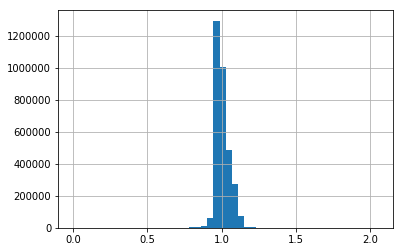

In [9]:
model_df.indice.hist(bins=50)

In [10]:
model_df.indice.describe()

count    3.240092e+06
mean     1.003949e+00
std      4.760355e-02
min      1.433224e-03
25%      9.740281e-01
50%      9.902849e-01
75%      1.030610e+00
max      2.051147e+00
Name: indice, dtype: float64

## Construction du vecteur de services

In [11]:
_tokenize = lambda x: x.split(',')
vectorize = CountVectorizer(tokenizer = _tokenize, lowercase=False)

In [12]:
matrice_services_df = (pd.SparseDataFrame(vectorize.fit_transform(df_services.services.fillna('Rien')),
                  df_services.id_station,
                  vectorize.get_feature_names(),
                  default_fill_value=0
                  ).reset_index())

In [15]:
model_df.merge(matrice_services_df,how='inner',on = ['id_station']).head()

,id_station,code_postal,type_station,libelle_carburant,date_releve,prix,prix_moyen,indice,Aire de camping-cars,Automate CB,...,Relais colis,Restauration sur place,Restauration à emporter,Rien,Station de gonflage,Station de lavage,Toilettes publiques,Vente de fioul domestique,Vente de gaz domestique,Vente de pétrole lampant
0,1000001,01000,R,E10,2015-02-09,1309.0,1308.978319,1.000017,0,1,...,0,0,0,0,1,0,0,0,1,0
1,1000001,01000,R,Gazole,2014-01-06,1304.0,1339.424795,0.973552,0,1,...,0,0,0,0,1,0,0,0,1,0
2,1000001,01000,R,Gazole,2014-01-13,1304.0,1332.461486,0.978640,0,1,...,0,0,0,0,1,0,0,0,1,0
3,1000001,01000,R,Gazole,2014-01-20,1304.0,1321.988856,0.986393,0,1,...,0,0,0,0,1,0,0,0,1,0
4,1000001,01000,R,Gazole,2014-01-27,1304.0,1323.724083,0.985100,0,1,...,0,0,0,0,1,0,0,0,1,0


In [14]:
(model_df
 .merge(matrice_services_df,how='outer',on=['id_station'],indicator=True)
['_merge']
.value_counts())

both          3220964
left_only       19128
right_only       1147
Name: _merge, dtype: int64

In [16]:
model_services_df = model_df.merge(matrice_services_df,how='inner',on = ['id_station'])

## Modele de regression linéaire

In [69]:
lr = LinearRegression(fit_intercept=True)

In [70]:
lr.fit(X=model_services_df[list(set(matrice_services_df)-{'id_station'})],y= model_services_df.indice)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
result = pd.DataFrame(
    [(feature, coef) for feature,coef in zip(list(set(matrice_services_df)-{'id_station'}),lr.coef_)],
    columns = ['Services','Coefficient']).sort_values('Coefficient',ascending=False)

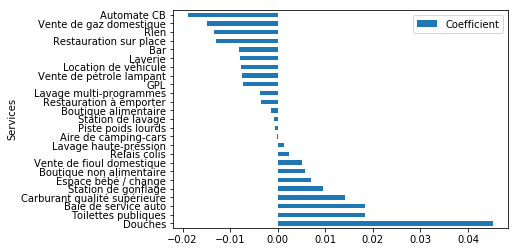

In [72]:
result.set_index('Services').plot(kind='barh')

In [76]:
result

,Services,Coefficient
12,Douches,0.045178
10,Toilettes publiques,0.018382
3,Baie de service auto,0.018346
13,Carburant qualité supérieure,0.014172
8,Station de gonflage,0.009450
14,Espace bébé / change,0.007004
2,Boutique non alimentaire,0.005735
5,Vente de fioul domestique,0.005004
9,Relais colis,0.002440
0,Lavage haute-pression,0.001274


In [75]:

X2 = sm.add_constant(model_services_df[list(set(matrice_services_df)-{'id_station'})])
est = sm.OLS(model_services_df.indice,X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 indice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 6.735e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:30:20   Log-Likelihood:             5.9143e+06
No. Observations:             3220964   AIC:                        -1.183e+07
Df Residuals:                 3220938   BIC:                        -1.183e+07
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Modele Random Regressor

In [58]:
rf = RandomForestRegressor()

In [59]:
rf.fit(X=model_services_df[list(set(matrice_services_df)-{'id_station'})],y= model_services_df.indice)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
result_rf = pd.DataFrame(
    [(feature, coef) for feature,coef in zip(list(set(matrice_services_df)-{'id_station'}),rf.feature_importances_)],
    columns = ['Services','Coefficient']).sort_values('Coefficient',ascending=False)

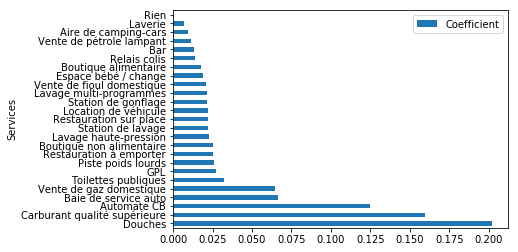

In [64]:
result_rf.set_index('Services').plot(kind='barh')